In [1]:
#Import custom modules
import boilerplate
import differential_equations
complex_unitary_log=boilerplate.complex_unitary_log
QFT=boilerplate.qft

#Import standard modules
import numpy as np
from scipy.optimize import minimize
from functools import partial
import scipy
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from matplotlib import pyplot as plt

In [2]:
#Example: For the q=1 case, calculate the complexity of the QFT for up to 10 qubits 

data_qft=[]

for N_qubits in range(1,10):

    
    #Get the one qubit QFT.
    operator = Operator(QFT(N_qubits))
    # Get the matrix representation
    U_target = operator.data
    
    Ham=complex_unitary_log(U_target)
    
    Hp=Ham-np.trace(Ham)*np.identity(2**N_qubits)/2**N_qubits
    
    cn=np.real(np.sqrt(np.trace(Hp@boilerplate.cal_G(Hp,4**N_qubits-1))/2**N_qubits))
    
    data_qft.append(cn)

data_qft=np.array(data_qft)

In [3]:
#Example: Calculate the complexity of the CNOT gate for up to 10 qubits

data_cnot=[]

for N_qubits in range(2,10):

    
    qc = QuantumCircuit(N_qubits)
    
    qc.cx(0, 1)
    
    #Get the one qubit QFT.
    operator = Operator(qc)
    # Get the matrix representation
    U_target = operator.data
    
    Ham=complex_unitary_log(U_target)
    
    
    
    Hp=Ham-np.trace(Ham)*np.identity(2**N_qubits)/2**N_qubits
    
    cn=np.real(np.sqrt(np.trace(Hp@boilerplate.cal_G(Hp,4**N_qubits-1))/2**N_qubits))
    
    data_cnot.append(cn)

data_cnot=np.array(data_cnot)

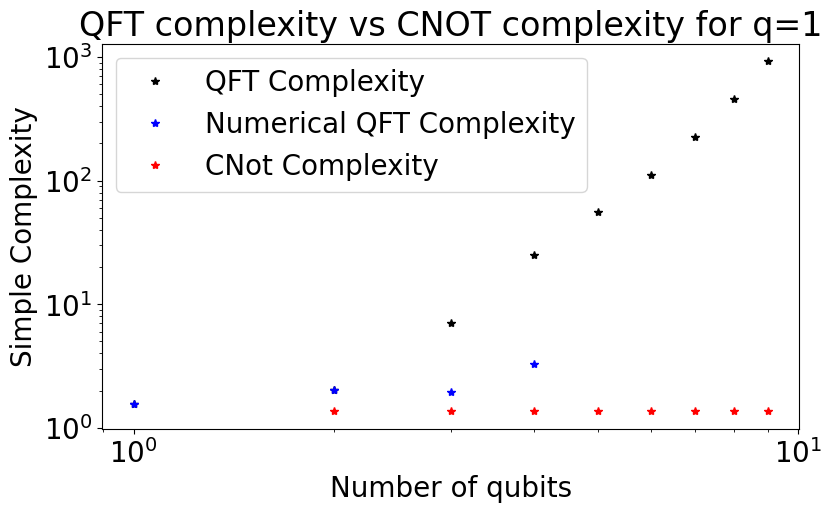

In [66]:
#Visualize results from examples
data_qft_numerical=[data_qft[0],data_qft[1],1.9472,3.2933]


plt.figure(figsize=(9,5))

nums_qft=np.array([x for x in range(1,10)])
nums_cnot=np.array([x for x in range(2,10)])

plt.title('QFT complexity vs CNOT complexity for q=1')
plt.loglog(nums_qft,np.array(data_qft),"k*",label="QFT Complexity")
plt.loglog(nums_qft[:len(data_qft_numerical)],np.array(data_qft_numerical),"b*",label="Numerical QFT Complexity")
plt.loglog(nums_cnot,np.array(data_cnot),"r*",label="CNot Complexity")
plt.legend()
plt.xlabel('Number of qubits')
plt.ylabel('Simple Complexity')
plt.savefig('simple_comp.png',dpi=600) #Saving enable by default
plt.show()


In [5]:
#Create setup for solving geodesic problem in case where q!=1.

#RHS of evolution equation for initial tangent vectors.
def rhs(q,Ham_vec):

    n=int(np.sqrt(len(Ham_vec)))
    
    #Ham_vec=lie_algebra_projector@Ham_vec
    
    f,g=boilerplate.get_F_G_matrices(N_qubits,q)
    
    Ham=np.reshape(Ham_vec,(n,n))
    
    #print(Ham)
    
    #print(np.trace(Ham))
    print(q)
    
    #Given the initial hamiltonian for this q, solve the geodesic-schrodinger equation
    sol=differential_equations.solve_matrix_ivp(Ham,N_qubits,q,0,1,N_t)
    time=sol[0]
    H_o_t=sol[1]
    U_o_t=sol[2]
    
    delta=scipy.linalg.expm(-1j*Hp)-U_o_t[-1]
    
    #print(np.real(np.trace(delta@delta.conj().T)))
    #print(U_o_t[-1]@U_o_t[-1].T.conj())
    
    dt=time[1]
    
    
    
    #Get Udagger
    U_dagger_o_t=np.transpose(U_o_t,(0,2,1)).conj()

    #Given solution to geodesic-schrodinger equation, computer the jacobi propagator
    A=boilerplate.cal_A(f,g,H_o_t,q) 
        
    K_prop=boilerplate.compute_propagator(A,dt)
    kshape=int(np.sqrt(np.shape(K_prop)[1]))
    k_tensor=np.reshape(K_prop,(K_prop.shape[0],kshape,kshape,kshape,kshape))
    
    J_prop=np.trapz(np.einsum('iad,idekl,ieb->iabkl',U_dagger_o_t,k_tensor,U_o_t),time,axis=0)

    
    J_mat=np.reshape(J_prop,(kshape**2,kshape**2))

    tolerance = 1e-10

    Jinv=np.linalg.inv(J_mat)
    tensor_dim=int(np.sqrt(Jinv.shape[0]))
    
    Jinv_tensor=np.reshape(Jinv,(tensor_dim,tensor_dim,tensor_dim,tensor_dim))

    tol=0.0000
    
    if q==1:
        jacobi_arg=differential_equations.approximate_matrix_integral(time,H_o_t,U_o_t)

        dhdq=np.einsum('ijkl,kl',Jinv_tensor,jacobi_arg)
    else:
        jacobi_arg=boilerplate.cal_G(Ham,q)

        dhdq=(np.einsum('ijkl,kl',Jinv_tensor,jacobi_arg)-jacobi_arg)/(q*(q-1))
        
    rhs_value=dhdq
    return rhs_value.flatten()


In [6]:
#Define function which solves the initial value problem specified by the rhs function and initial conditions
def solve_ivp(
    h_nought,
    n_qubits,
    n_points,
):
    q0=1.00
    qf=4**(n_qubits)-1
    
    if h_nought.shape[0] != (1 << n_qubits):

        raise ValueError
    
    y0 =h_nought.flatten()
    
    result = scipy.integrate.solve_ivp(
        rhs,
        t_span=(q0,qf),
        y0=y0,
        t_eval=np.logspace(np.log10(q0), np.log10(qf), n_points),
        method='RK45'#,
        #rtol=10**-15,
        #atol=10**-16
    )

#    result=forward_euler(rhs88,y0,np.linspace(q0,qf,n_points))

    h_values = result.y
    
    h_mat=np.reshape(h_values,(n_points,2**n_qubits,2**n_qubits))
    
    

    return result.t, h_values

In [53]:
#Create set up for using the above solver

#Number of qubits, and initial q value
N_qubits=3
q=1

#Number of time slices and q slices we consider.
N_t=101
N_q=100

#Get the N-qubit QFT.
operator = Operator(QFT(N_qubits))
# Get the matrix representation
U_target = operator.data

#Get the Hamiltonian for the q=1 t=0 case.
Ham=complex_unitary_log(U_target)

#Subtract constant term which contributes a global phase. This is our initial condition
Hp=Ham-np.trace(Ham)*np.identity(2**N_qubits)/2**N_qubits 

#Calculate the solution
sol=solve_ivp(Hp,N_qubits,N_q)


1.0
1.0019430993338572
1.0076635613832996
1.0114953420749493
1.0306542455331982
1.0340602728146646
1.0383178069164978
1.0383178069164978
1.0497298006688849
1.0554357975450785
1.0839657819260462
1.0890377791493293
1.0953777756784333
1.0953777756784333
1.119721193281164
1.131892902082529
1.1927514460893553
1.2035707428016802
1.217094863692086
1.217094863692086
1.2571851605820494
1.2772303090270312
1.37745605125194
1.3952739609808127
1.4175463481419035
1.4175463481419035
1.5025812950773088
1.5450987685450115
1.7576861358835247
1.7954794456325938
1.84272108281893
1.84272108281893
1.978368981616736
2.046192931015639
2.3853126780101537
2.445600633031401
2.5209605768079597
2.5209605768079597
2.7699636966996097
2.894465256645435
3.5169730563745607
3.6276411096597383
3.7659761762662107
3.7659761762662107
4.216156749515215
4.441247036139718
5.566698469262229
5.766778724039564
6.016879042511233
6.016879042511233
6.7883704753710274
7.174116191800925
9.102844773950412
9.445729855221431
9.8743362068

In [54]:
#Calculate complexity vs. the penalty factor based on solution

cn3_data=[]

coeff_data_P=[]
coeff_data_Q=[]

ham_hist=sol[1]
q_vals=sol[0]

#Count the number of two body terms
NP=0
for signature in boilerplate.generate_pauli_signatures(N_qubits):
    if signature[0]<=2:
        NP+=1


for i,h in enumerate(ham_hist.T):
    ham_final=np.reshape(h,(2**N_qubits,2**N_qubits))
    
    #print(ham_final)
    
    sold=differential_equations.solve_matrix_ivp(ham_final,N_qubits,q_vals[i],0,1,N_t)

    time=sold[0]
    H_o_t=sold[1]
    
    
    coeff_datum=[]
    for signature in boilerplate.generate_P_signatures(n_qubits=N_qubits):
        coeff, basis_matrix = boilerplate.get_coeff_and_basis(H_o_t[-1], pauli_signature=signature)
        coeff_datum.append(coeff)
    coeff_data_P.append(coeff_datum)
    
    coeff_datum=[]
    for signature in boilerplate.generate_pauli_signatures(N_qubits):
        coeff, basis_matrix = boilerplate.get_coeff_and_basis(H_o_t[-1], signature[1])
        weight=N_qubits-signature.count('I')
        if signature[0]>2:
            coeff_datum.append(coeff)
        
    coeff_data_Q.append(coeff_datum)
    

    integrand=[]
    for ht in H_o_t:
        integrand.append(np.sqrt(np.trace(ht@boilerplate.cal_G(ht,q_vals[i]))/2**N_qubits))
    c3=np.trapz(integrand,time)
    #c3=np.real(np.sqrt(np.trace(ham_final@boilerplate.cal_G(ham_final,q_vals[i]))))/2**N_qubits
    cn3_data.append(c3)

coeff_data_P_bottom=coeff_data_P

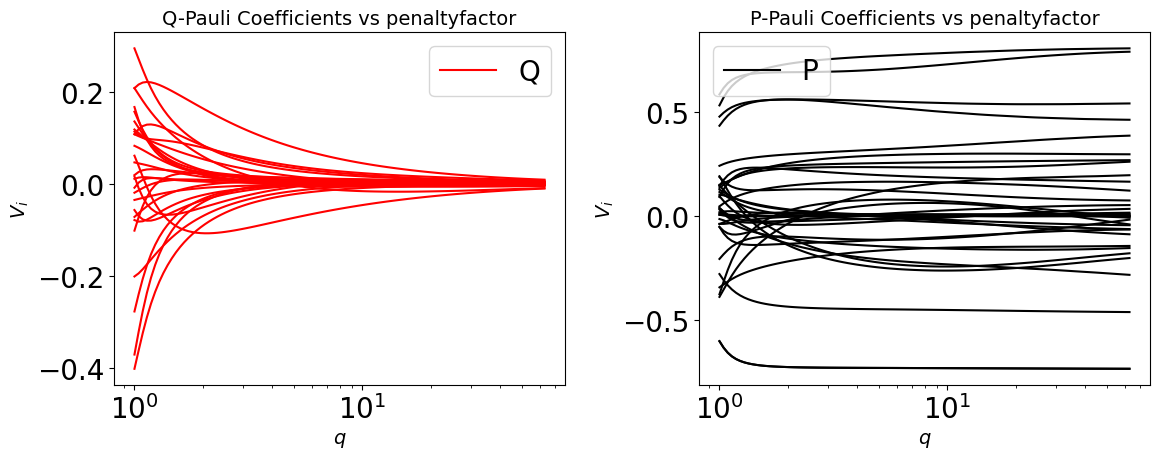

In [55]:
#Make a plot of initial tangent vectors vs. penalty factor.

fig, axs=plt.subplots(1,2,figsize=(12,5))

axs[0].semilogx(q_vals,np.array(coeff_data_Q),color='r')
axs[0].semilogx([],[],label='Q',color='r')
axs[1].semilogx(q_vals,coeff_data_P,color='k')
axs[1].semilogx([],[],label='P',color='k')
axs[0].legend()
axs[1].legend()
axs[0].set_title('Q-Pauli Coefficients vs penaltyfactor',fontsize='14')
axs[1].set_title('P-Pauli Coefficients vs penaltyfactor',fontsize='14')
axs[0].set_ylabel(r'$V_i$',fontsize='14')
axs[1].set_ylabel(r'$V_i$',fontsize='14')
axs[0].set_xlabel(r'$q$',fontsize='14')
axs[1].set_xlabel(r'$q$',fontsize='14')
#axs[0].set_ylim(axs[1].get_ylim())
plt.tight_layout()
plt.savefig(f'QFT_coeffs_v_q_{N_qubits}_qubits.png',dpi=600)
np.save(f'q_vals_{N_qubits}_qubits.npy',q_vals)
np.save(f'coeff_data_P_{N_qubits}_qubits.npy',coeff_data_P)
np.save(f'coeff_data_Q_{N_qubits}_qubits.npy',coeff_data_Q)
plt.show()


In [56]:
#Complexity of the circuit
print(np.real(cn3_data[-1]))

1.9471750571059392


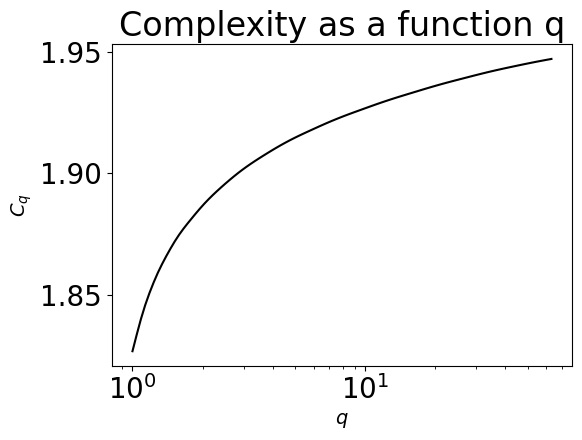

In [57]:
#Make a plot of the complexity vs q

plt.figure()
plt.semilogx(q_vals,np.real(cn3_data),color='k')
plt.ylabel(r'$C_q$',fontsize='14')
plt.title('Complexity as a function q')

plt.xlabel(r'$q$',fontsize='14')
plt.tight_layout()
plt.savefig('Complexity_v_q.png',dpi=600)
np.save(f'Complexity_v_q_qft_{N_qubits}_qubits.png',np.real(cn3_data))
plt.show()


In [58]:
#Calculate the unitary evolution along the final geodesic, and calculate residual vs time. 

Ut_new=scipy.linalg.expm(-1j*Hp)

H_coeff_data_P=[]
H_coeff_data_Q=[]



ham_final=np.reshape(ham_hist.T[-1],(2**N_qubits,2**N_qubits))

sol=differential_equations.solve_matrix_ivp(ham_final,N_qubits,4**N_qubits-1,0,1,N_t)

time=sol[0]
H_o_t=sol[1]
U_o_t=sol[2]

U_norm_data=[]


for i,ht in enumerate(H_o_t):
    
    
    coeff_datum=[]
    for signature in boilerplate.generate_P_signatures(n_qubits=N_qubits):
        coeff, basis_matrix = boilerplate.get_coeff_and_basis(ht, pauli_signature=signature)
        coeff_datum.append(coeff)
    H_coeff_data_P.append(coeff_datum)
    
    coeff_datum=[]
    for signature in boilerplate.generate_pauli_signatures(N_qubits):
        coeff, basis_matrix = boilerplate.get_coeff_and_basis(ht, signature[1])
        weight=N_qubits-signature[1].count('i')

        if weight>2:
            coeff_datum.append(coeff)
    H_coeff_data_Q.append(coeff_datum)
    
    delta_U=Ut_new-U_o_t[i]

    
    
    U_norm_data.append(np.sqrt(np.trace(delta_U@delta_U.T.conj())/2**N_qubits))
    

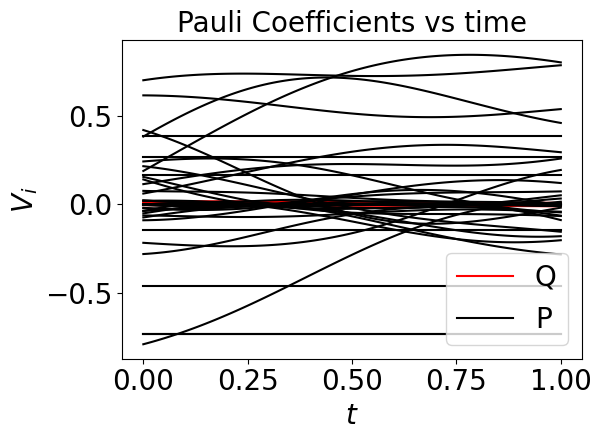

In [59]:
#Make a plot of tangent vectors vs time.
plt.figure()
plt.rcParams.update({'font.size': 20})  # Set the default font size to 14
plt.plot(time,H_coeff_data_Q,color='r')
plt.plot([],[],label='Q',color='r')
plt.plot(time,H_coeff_data_P,color='k')
plt.plot([],[],label='P',color='k')
plt.legend()
plt.title('Pauli Coefficients vs time',fontsize='20')
plt.ylabel(r'$V_i$',fontsize='20')
plt.xlabel(r'$t$',fontsize='20')
plt.tight_layout()
plt.savefig(f'QFT_v_time_{N_qubits}_qubits.png',dpi=600)
plt.show()


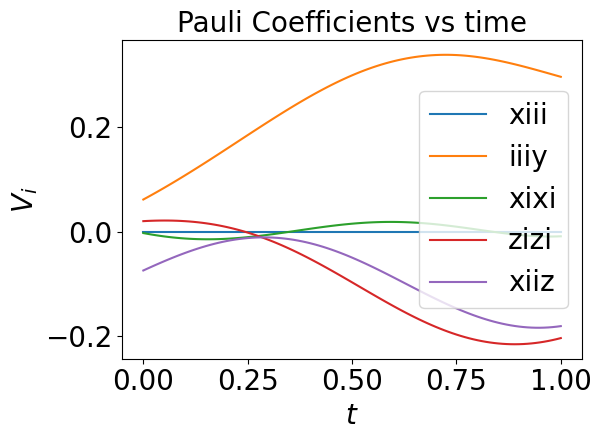

In [60]:
#Make a plot with labels of certain tangent vectors

num_strings=[0,10,21,29,32]

sigs=[]
for sig in boilerplate.generate_P_signatures(n_qubits=4):
    sigs.append(sig)

plt.figure()
plt.rcParams.update({'font.size': 20})  # Set the default font size to 14
for num in num_strings:
    plt.plot(time,np.array(H_coeff_data_P)[:,num],label=sigs[num])
    #plt.plot([],[],label='P',color='k')
#plt.legend(loc='upper left',bbox_to_anchor=(1.05,1))
plt.legend()
#plt.xlim([0,1.55])
plt.title('Pauli Coefficients vs time',fontsize='20')
plt.ylabel(r'$V_i$',fontsize='20')
plt.xlabel(r'$t$',fontsize='20')
plt.tight_layout()
plt.savefig(f'QFT_Coeffs_{N_qubits}_qubits.png',dpi=600)
plt.show()


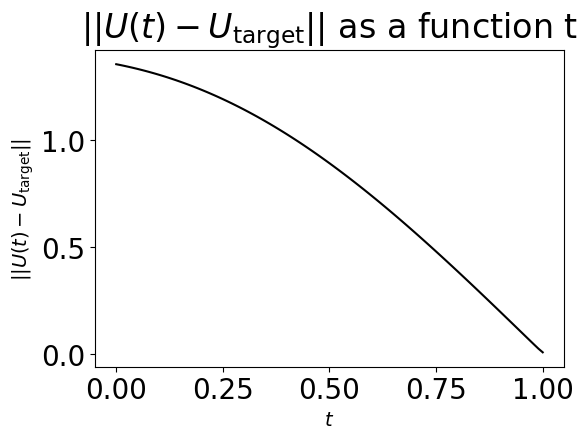

In [61]:
#Plot residual vs time (should approach zero)
plt.figure()
plt.plot(time,U_norm_data,color='k')
plt.ylabel(r'$||U(t)-U_{\mathrm{target}}||$',fontsize='14')
plt.title(r'$||U(t)-U_{\mathrm{target}}||$ as a function t')
plt.xlabel(r'$t$',fontsize='14')
plt.tight_layout()
plt.savefig(f'du_QFT_{N_qubits}_qubits.png',dpi=600)
plt.show()


In [62]:
QFT(N_qubits).draw('mpl').savefig(f'QFT_{N_qubits}_qubits.png',dpi=600)